# Plot RV curves

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

JAX version! see https://jax.exoplanet.codes/en/latest/tutorials/core-from-scratch/

In [2]:
import pylab
import matplotlib.pyplot as plt
import numpy as np
#from PyAstronomy import pyasl
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PyAstronomy import pyasl

In [3]:
import jax
import jax.numpy as jnp


# Enabling double precision for comparison with standard methods from
# the literature, but everything here also works at lower precision
jax.config.update("jax_enable_x64", True)


def kepler_starter(mean_anom, ecc):
    ome = 1 - ecc
    M2 = jnp.square(mean_anom)
    alpha = 3 * jnp.pi / (jnp.pi - 6 / jnp.pi)
    alpha += 1.6 / (jnp.pi - 6 / jnp.pi) * (jnp.pi - mean_anom) / (1 + ecc)
    d = 3 * ome + alpha * ecc
    alphad = alpha * d
    r = (3 * alphad * (d - ome) + M2) * mean_anom
    q = 2 * alphad * ome - M2
    q2 = jnp.square(q)
    w = jnp.square(jnp.cbrt(jnp.abs(r) + jnp.sqrt(q2 * q + r * r)))
    return (2 * r * w / (jnp.square(w) + w * q + q2) + mean_anom) / d

def kepler_refiner(mean_anom, ecc, ecc_anom):
    ome = 1 - ecc
    sE = ecc_anom - jnp.sin(ecc_anom)
    cE = 1 - jnp.cos(ecc_anom)

    f_0 = ecc * sE + ecc_anom * ome - mean_anom
    f_1 = ecc * cE + ome
    f_2 = ecc * (ecc_anom - sE)
    f_3 = 1 - f_1
    d_3 = -f_0 / (f_1 - 0.5 * f_0 * f_2 / f_1)
    d_4 = -f_0 / (f_1 + 0.5 * d_3 * f_2 + (d_3 * d_3) * f_3 / 6)
    d_42 = d_4 * d_4
    dE = -f_0 / (f_1 + 0.5 * d_4 * f_2 + d_4 * d_4 * f_3 / 6 - d_42 * d_4 * f_2 / 24)

    return ecc_anom + dE

@jax.jit
@jnp.vectorize
def getE(mean_anom, ecc):
    mean_anom = mean_anom % (2 * jnp.pi)

    # We restrict to the range [0, pi)
    high = mean_anom > jnp.pi
    mean_anom = jnp.where(high, 2 * jnp.pi - mean_anom, mean_anom)

    # Solve
    ecc_anom = kepler_starter(mean_anom, ecc)
    ecc_anom = kepler_refiner(mean_anom, ecc, ecc_anom)

    # Re-wrap back into the full range
    ecc_anom = jnp.where(high, 2 * jnp.pi - ecc_anom, ecc_anom)

    return ecc_anom


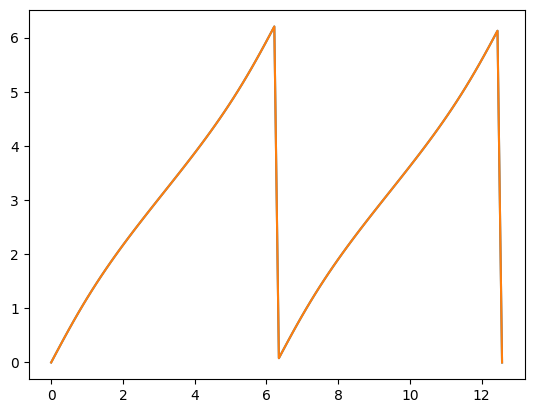

In [4]:


ks = pyasl.MarkleyKESolver()
e = 0.2 
mean_anomaly = jnp.linspace(0, 4 * jnp.pi, 100)
eccentric_anomaly = []
for m in mean_anomaly:
    eccentric_anomaly.append(ks.getE(m, e))
eccentric_anomaly = jnp.array(eccentric_anomaly)

plt.plot(mean_anomaly,eccentric_anomaly, label="MarkleyKE")  
plt.plot(mean_anomaly, getE(mean_anomaly, e), label="JAX")


In [11]:
def getrv_numpy(e,omega):
    vp=0.0
    Ksini=1.0
    M=np.linspace(0.0,4*np.pi,1000)
    cosfpo=[]
    for Meach in M:
        Eeach=getE(Meach, e) #eccentric anomaly
        cosEeach=np.cos(Eeach)
        cosf=(-cosEeach + e)/(-1 + cosEeach*e)
        if Eeach < np.pi:
            sinf=-np.sqrt((-1 + cosEeach*cosEeach)*(-1 + e*e))/(-1 + cosEeach*e)
        else:
            sinf=np.sqrt((-1 + cosEeach*cosEeach)*(-1 + e*e))/(-1 + cosEeach*e)

        cosfpoeach=cosf*np.cos(omega)-sinf*np.sin(omega)
        cosfpo.append(cosfpoeach)

    cosfpo=np.array(cosfpo)
    face=1.0/np.sqrt(1.0-e*e)
    model = vp+Ksini*face*(cosfpo+e*np.cos(omega))
    return M, model

In [16]:
import jax
import jax.numpy as jnp


# -------------------------------------------------
# JAX‑compatible implementation
# -------------------------------------------------



@jax.jit
def get_rv(e: float, omega: float, mean_anomaly: jnp.ndarray) -> jnp.ndarray:
    """Compute radial‑velocity model without explicit Python loops.

    Args:
        e (float): eccentricity (0 ≤ e < 1).
        omega (float): argument of periastron [rad].
        mean_anomaly (jnp.ndarray): mean anomaly [rad], shape (num,).
    Returns:
        model (jnp.ndarray): RV model on the same grid, shape (num,).
    """
    vp = 0.0
    Ksini = 1.0

    # Mean‑anomaly grid
    
    # Vectorised solution of Kepler's equation
    E = jax.vmap(lambda m: getE(m, e))(mean_anomaly)       # shape (num,)

    # True‑anomaly related quantities
    cosE = jnp.cos(E)
    cosf = (-cosE + e) / (-1.0 + cosE * e)

    sinf_base = jnp.sqrt((1.0 - cosE**2) * (1.0 - e**2)) / (-1.0 + cosE * e)
    # sign flip depending on E
    sinf = jnp.where(E < jnp.pi, -sinf_base, sinf_base)

    # Projected cosine term
    cosfpo = cosf * jnp.cos(omega) - sinf * jnp.sin(omega)

    # RV curve
    face = 1.0 / jnp.sqrt(1.0 - e * e)
    model = vp + Ksini * face * (cosfpo + e * jnp.cos(omega))

    return model


In [15]:
def conic(e,omega):
    t=np.linspace(-2*np.pi,2*np.pi,1000)
    f=t-omega
    r=(1-e**2)/(1+e*np.cos(f))
    x=r*np.cos(t)
    y=r*np.sin(t)
    return x,y

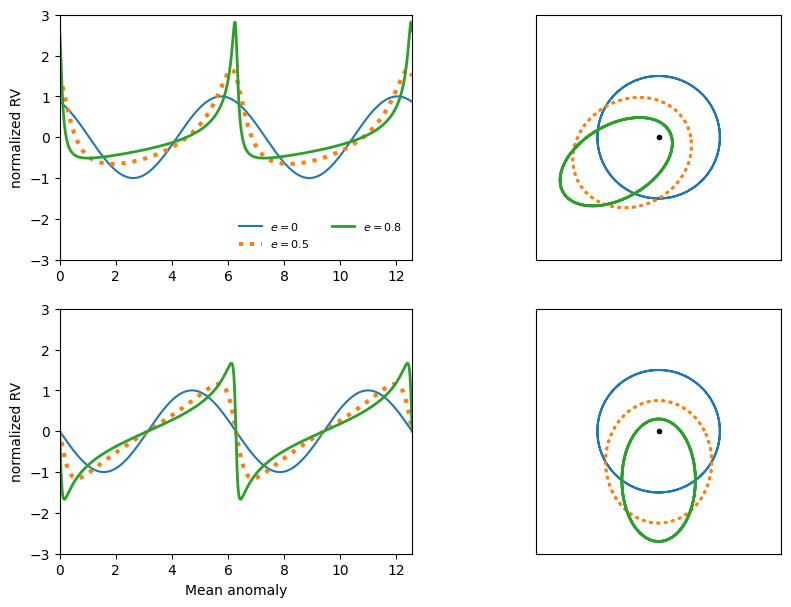

In [19]:
M = jnp.linspace(0.0, 4.0 * jnp.pi, 1000)


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(221)
pylab.ylim(-3, 3)
pylab.xlim(0.0, 4 * np.pi)
model = get_rv(0.0, np.pi / 6, M)
ax.plot(M, model, color="C0")
model = get_rv(0.5, np.pi / 6, M)
ax.plot(M, model, color="C1", ls="dotted", lw=3)
model = get_rv(0.8, np.pi / 6, M)
ax.plot(M, model, color="C2", lw=2)
plt.legend(
    ["$e=0$", "$e=0.5$", "$e=0.8$"],
    loc="lower right",
    prop={"size": 8},
    frameon=False,
    ncol=2,
)
#
pylab.ylabel("normalized RV")

ax = fig.add_subplot(223)
pylab.ylim(-3, 3)
pylab.xlim(0.0, 4 * np.pi)
model = get_rv(0.0, np.pi / 2, M)
ax.plot(M, model, color="C0")
model = get_rv(0.5, np.pi / 2, M)
ax.plot(M, model, color="C1", ls="dotted", lw=3)
model = get_rv(0.8, np.pi / 2, M)
ax.plot(M, model, color="C2", lw=2)
pylab.ylabel("normalized RV")
pylab.xlabel("Mean anomaly")

ax = fig.add_subplot(222)
pylab.ylim(-2, 2)
pylab.xlim(-2, 2)
x, y = conic(0.0, np.pi / 6)
ax.plot(x, y, color="C0")
x, y = conic(0.5, np.pi / 6)
ax.plot(x, y, color="C1", ls="dotted", lw=2)
x, y = conic(0.8, np.pi / 6)
ax.plot([0], [0], ".", color="black", lw=2)
ax.plot(x, y, color="C2", lw=2)
ax.set_aspect(1.0 / ax.get_data_ratio())
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])

ax = fig.add_subplot(224)
pylab.ylim(-2, 2)
pylab.xlim(-2, 2)
x, y = conic(0.0, np.pi / 2)
ax.plot(x, y, color="C0")
x, y = conic(0.5, np.pi / 2)
ax.plot(x, y, color="C1", ls="dotted", lw=2)
x, y = conic(0.8, np.pi / 2)
ax.plot(x, y, color="C2", lw=2)
ax.plot([0], [0], ".", color="black")
ax.set_aspect(1.0 / ax.get_data_ratio())
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.show()

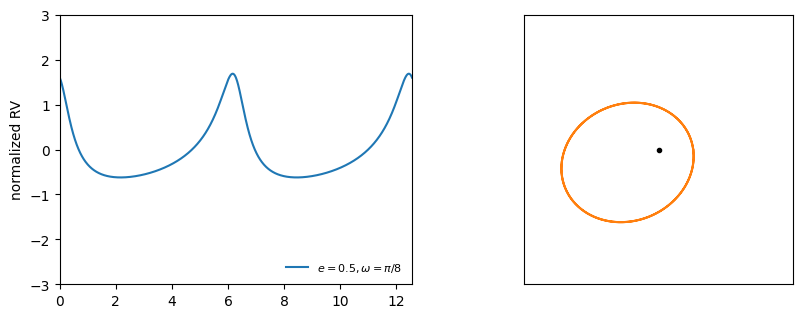

In [21]:
fig = plt.figure(figsize=(10, 3.5))
ax = fig.add_subplot(121)
pylab.ylim(-3, 3)
pylab.xlim(0.0, 4 * np.pi)
model = get_rv(0.5, np.pi / 8, M)
ax.plot(M, model, color="C0")

plt.legend(
    ["$e=0.5, \omega=\pi/8$"],
    loc="lower right",
    prop={"size": 8},
    frameon=False,
    ncol=2,
)
#
pylab.ylabel("normalized RV")

ax = fig.add_subplot(122)
pylab.ylim(-2, 2)
pylab.xlim(-2, 2)
x, y = conic(0.5, np.pi / 8)
ax.plot(x, y, color="C1")
ax.plot([0], [0], ".", color="black")
ax.set_aspect(1.0 / ax.get_data_ratio())
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.show()

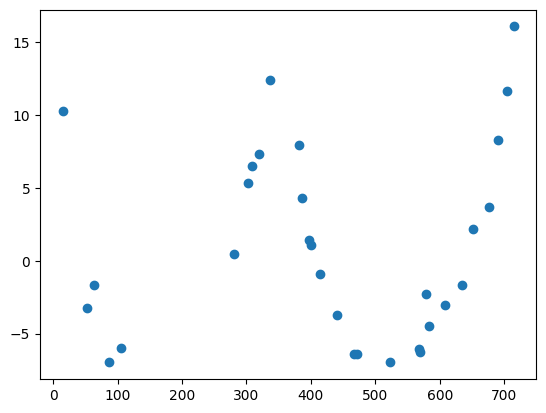

In [40]:
np.random.seed(0)

ein = 0.5
omegain = np.pi / 8
main = np.random.uniform(0, 4 * np.pi, 30)
main = np.sort(main)
mock_model = get_rv(ein, omegain, main)
Kpin = 10 #cm/s
Vsys = 0.0
noise_std = 1.0
mock_rv = Kpin*mock_model + Vsys + np.random.normal(0, noise_std, len(mock_model))

P = 365.0 #day
tobs = P*main/(2*np.pi)

plt.plot(tobs, mock_rv, "o", color="C0", label="mock data")

In [52]:
def model_rv(e, omega, Kp, Vsys, P, T0):
    ma = (tobs - T0) * (2 * jnp.pi) / P
    nomralized_rv = get_rv(e, omega, ma)

    return Kp * nomralized_rv + Vsys

In [42]:
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
import numpyro
from jax import random

In [53]:
def model_prob(rv):

    e = numpyro.sample("e", dist.Uniform(0.0, 1.0))
    omega = numpyro.sample("omega", dist.Uniform(0.0, 2 * jnp.pi))
    Kp = numpyro.sample("Kp", dist.Uniform(5.0, 15.0))
    Vsys = numpyro.sample("Vsys", dist.Uniform(-1.0, 1.0))
    P = numpyro.sample("P", dist.Uniform(300.0, 400.0))
    T0 = numpyro.sample("T0", dist.Uniform(-10.0, 10.0))

    mu = model_rv(e, omega, Kp, Vsys, P, T0)

    # noise model parameters priors
    sigmain = numpyro.sample("sigmain", dist.Exponential(1.0))

    numpyro.sample("rv", dist.Normal(mu, sigmain), obs=rv)

In [54]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 500, 1000
#kernel = NUTS(model_prob, forward_mode_differentiation=True)
kernel = NUTS(model_prob, forward_mode_differentiation=False)

In [55]:
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key_, rv=mock_rv)
mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [00:17<00:00, 85.84it/s, 15 steps of size 2.20e-01. acc. prob=0.92] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        Kp      9.89      0.46      9.87      9.20     10.71    468.46      1.00
         P    364.84      2.37    364.98    361.39    368.99    515.06      1.00
        T0     -2.20      3.42     -2.34     -7.87      3.27    496.57      1.00
      Vsys     -0.23      0.29     -0.22     -0.75      0.22    533.90      1.00
         e      0.47      0.04      0.47      0.41      0.53    590.84      1.00
     omega      0.35      0.07      0.35      0.24      0.45    589.58      1.00
   sigmain      1.24      0.18      1.22      0.94      1.51    533.05      1.00

Number of divergences: 0


In [56]:
from numpyro.diagnostics import hpdi
from numpyro.infer import Predictive
import jax.numpy as jnp


In [57]:
# SAMPLING
posterior_sample = mcmc.get_samples()
pred = Predictive(model_prob, posterior_sample, return_sites=['rv'])
predictions = pred(rng_key_, rv=None)
median_mu1 = jnp.median(predictions['rv'], axis=0)
hpdi_mu1 = hpdi(predictions['rv'], 0.9)

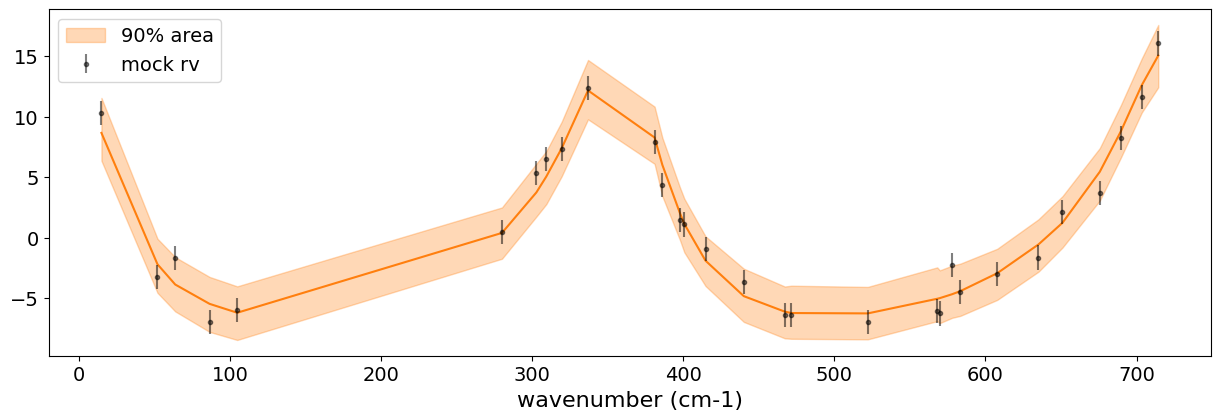

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4.5))
ax.plot(tobs, median_mu1, color='C1')
ax.fill_between(tobs,
                hpdi_mu1[0],
                hpdi_mu1[1],
                alpha=0.3,
                interpolate=True,
                color='C1',
                label='90% area')
ax.errorbar(tobs, mock_rv, 1.0*np.ones_like(tobs), fmt=".", label="mock rv", color="black",alpha=0.5)
plt.xlabel('wavenumber (cm-1)', fontsize=16)
plt.legend(fontsize=14)
plt.tick_params(labelsize=14)
plt.show()


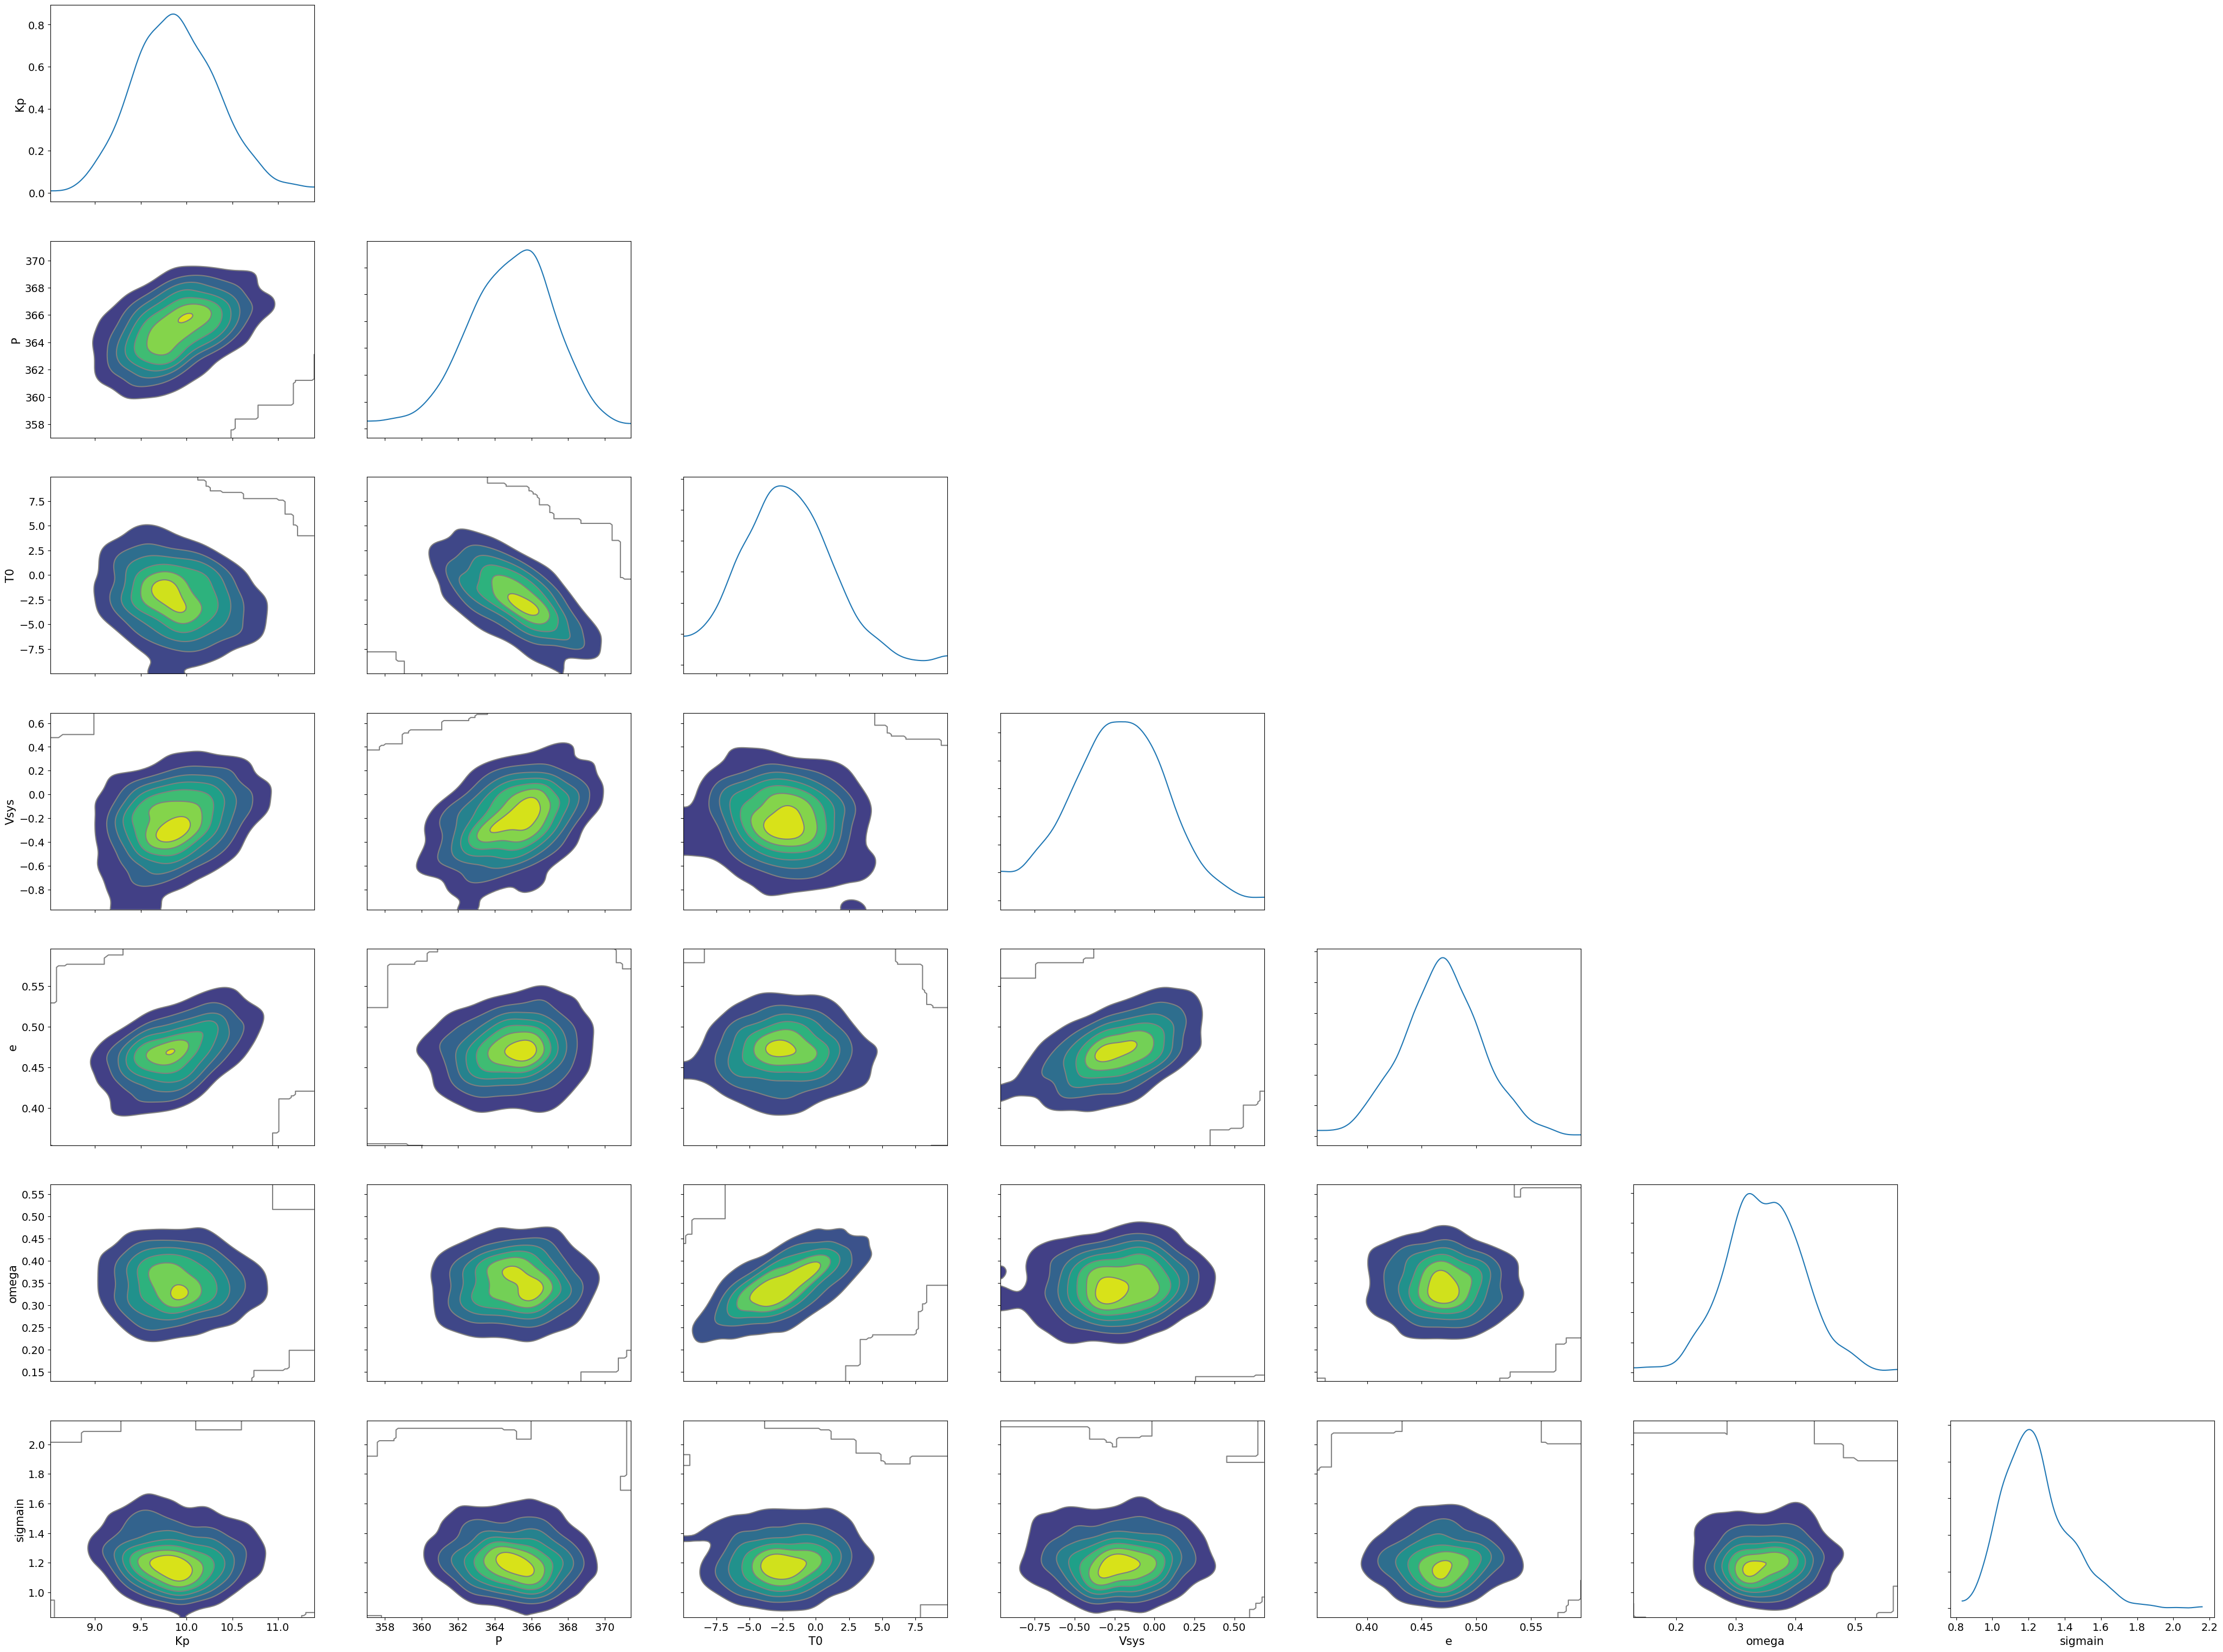

In [59]:
import arviz
pararr = ['e', 'omega', 'Kp', 'P', 'Vsys', 'sigmain', 'T0']
arviz.plot_pair(arviz.from_numpyro(mcmc),
                kind='kde',
                divergences=False,
                marginals=True)
plt.show()

In [50]:
np.savetxt("rvmock.csv",np.array([tobs,mock_rv]).T,delimiter=",",header="tobs (day), rv (cm/s)")
